In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from numpy.core.fromnumeric import squeeze
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression 
from sklearn.feature_selection import f_classif, mutual_info_classif, f_regression, mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer
from imblearn.metrics import macro_averaged_mean_absolute_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

In [37]:
#importo il dataset
df = pd.read_csv('data_football_ratings.csv')

In [38]:
#differenziare tra centrocampisti centrali (MF) e i centrocampisti difensivi (DMF) e i centrocampisti offensivi (AMF)
df.loc[df.pos_role == 'DMC', 'pos'] = 'DMF'
df.loc[df.pos_role == 'DMR', 'pos'] = 'DMF'
df.loc[df.pos_role == 'DML', 'pos'] = 'DMF'

df.loc[df.pos_role == 'AMC', 'pos'] = 'AMF'
df.loc[df.pos_role == 'AMR', 'pos'] = 'AMF'
df.loc[df.pos_role == 'AML', 'pos'] = 'AMF'

In [39]:
#in pos, al posto di Sub metto "nan", in questo modo poi quando si fa la media, la funzione mode() non considera "Sub" come un ruolo, ma scarta direttamente i nan, non li considera
df.loc[df.pos == 'Sub','pos'] = np.nan

#per ogni calciatore calcolo la moda delle loro posizioni, in modo da assegnare la posizione alle istanze che non ce l'hanno, che hanno 'Sub' invece che la loro vera posizione
#creo un altro dataframe in cui abbiamo calciatore e la loro posizione, calcolata condiserando la loro posizione che è occorsa più volte nel dataset (moda)
df_reduced = df.groupby('player').pos.agg(pd.Series.mode).to_frame('moda_pos').reset_index()

#elimino tutte le istanze per cui non si è potuto stabilire una moda (erano tutti Sub/nan) o una moda univoca (c'erano 1 MF e 1 DF)
df_reduced.drop([9,12,21,22,37,39,44,51,52,56,67,68,78,90,92,101,119,125,129,135,142,149,164,170,176,177,179,180,182,189,207,217,227,235,239,245,257,258,259,266,272,294,301,310,313,321,323,338,351,371,384,394,402,403,414,415,423,438,444,445,453,457,467,473,475,480,489,491,501,504,515,516,531,538,550,578,583,584,602,603,604,616,621,628,630,636,643,645,664,678,684,695,702,713,719,734,738,745,757,761,762,766,785,790,791,795,809,812,825,836,844,850,854,871,879,891,897,898,899,911,916,919,923,928,929,933,937,942,945,982,994,999,1017,1040,1043,1048,1058,1060,1070,1082,1084,1091,1093,1095,1099,1106,1114,1117,1122,1130,1138,1140,1141,1144,1163,1165,1175,1191,1194,1198,1203,1203,1208,1210,1213,1214,1222,1229,1246,1253,1259,1265,1267,1281,1287,1288,1292,1293,1312,1328,1330,1346,1348,1368,1373,1375,1414,1415,1418,1421,1422,1430,1431,1433,1437,1440,1444,1446,1459,1464,1478,1495,1526,1531,1533,1535,1537,1576,1588,1603,1617], inplace= True)

df_reduced.loc[df_reduced.player =='Diafra Sakho','moda_pos'] = 'FW'
df_reduced.loc[df_reduced.player =='Julien Ngoy','moda_pos'] = 'FW'
df_reduced.loc[df_reduced.player =='Carlos Sanchez','moda_pos'] = 'MF'
df_reduced.loc[df_reduced.player =='Christoph Janker','moda_pos'] = 'DF'
df_reduced.loc[df_reduced.player =='Riechedly Bazoer','moda_pos'] = 'MF'
df_reduced.loc[df_reduced.player =='Sebastian Maier','moda_pos'] = 'MF'

#join tra df e reduced_df in modo da aggiungere a ogni (tutti) calciatore la sua posizione "preferita" e allo stesso tempo elimino le istanze dove pos == 'Sub' 
#ma non era possibile stabilire la posizione perchè non compariva mai per quel calciatore oppure a causa di una moda non unica
df_merged = pd.merge(df,df_reduced, on = 'player')

#riempio i NaN in 'pos' con la posizione di quel calciatore
df_merged.loc[df_merged.pos_role == 'Sub','pos'] = df_merged.moda_pos

#creo una colonna "starter", utilizzando l'informazione di pos_role. Starter=1 significa che è partito titolare, 0 se subentrato
fill_starter = lambda x: 0 if x == 'Sub' else 1
df_merged['starter'] = df_merged.pos_role.apply(fill_starter)

In [40]:
#cambio l'ordine dei rating tedeschi in modo che vadano in ordine crescente da 1 a 6: 6 best performance
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 1), 'original_rating'] = 'a'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 1.5), 'original_rating'] = 'b'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 2), 'original_rating'] = 'c'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 2.5), 'original_rating'] = 'd'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 3), 'original_rating'] = 'e'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 4), 'original_rating'] = 'f'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 4.5), 'original_rating'] = 'g'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 5), 'original_rating'] = 'h'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 5.5), 'original_rating'] = 'i'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 6), 'original_rating'] = 'l'


df_merged.loc[df_merged.original_rating == 'a', 'original_rating'] = 6
df_merged.loc[df_merged.original_rating == 'b', 'original_rating'] = 5.5
df_merged.loc[df_merged.original_rating == 'c', 'original_rating'] = 5
df_merged.loc[df_merged.original_rating == 'd', 'original_rating'] = 4.5
df_merged.loc[df_merged.original_rating == 'e', 'original_rating'] = 4
df_merged.loc[df_merged.original_rating == 'f', 'original_rating'] = 3
df_merged.loc[df_merged.original_rating == 'g', 'original_rating'] = 2.5
df_merged.loc[df_merged.original_rating == 'h', 'original_rating'] = 2
df_merged.loc[df_merged.original_rating == 'i', 'original_rating'] = 1.5
df_merged.loc[df_merged.original_rating == 'l', 'original_rating'] = 1


In [41]:
df_merged = df_merged.assign(rating=pd.Series(np.random.randn(49700)).values)

In [42]:
#creo dataset uno per ogni rater
df_kicker = df_merged[df_merged.rater == 'Kicker']
df_kicker = df_kicker.reset_index()

df_bild = df_merged[df_merged.rater == 'Bild']
df_bild = df_bild.reset_index()

df_h_10 = df_merged[(df_merged.rater == 'TheGuardian') | (df_merged.rater == 'SkySports')]
df_h_10 = df_h_10.reset_index()

df_nh = df_merged[(df_merged.rater == 'WhoScored') | (df_merged.rater == 'SofaScore')]
df_nh = df_nh.reset_index()

df_guardian = df_merged[(df_merged.rater == 'TheGuardian')]
df_ss = df_merged[(df_merged.rater == 'SkySports')]
df_sofa = df_merged[(df_merged.rater == 'SofaScore')]
df_wsc = df_merged[(df_merged.rater == 'WhoScored')]

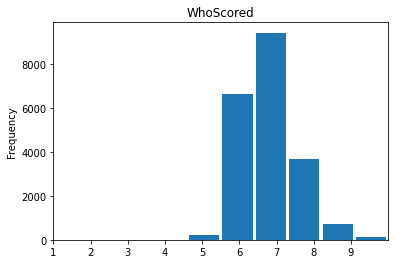

In [43]:

df_wsc.original_rating.plot.hist(bins=10, title = 'WhoScored', rwidth=0.9, range=[1,10])

plt.xlim([1, 10])
plt.xticks(np.arange(1, 10, 1))

plt.show()

Calcolo gli split point per ogni rater, poi discretizzo i ratings

In [44]:
#KICKER
vect_k = df_kicker.original_rating
vect_k = np.array(vect_k)
vect_k = vect_k.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 6, encode='ordinal', strategy='kmeans')
vect_k = trans.fit_transform(vect_k)

trans.bin_edges_

array([array([1.        , 1.7996184 , 2.74372969, 3.61271594, 4.34664871,
              5.17176608, 6.        ])                                   ],
      dtype=object)

In [45]:
#BILD
#prendo la serie (colonna original_rating di df_bild)
vect_b = df_bild.original_rating
#trasformo in array
vect_b = np.array(vect_b)
#array deve essere nella forma n x 1
vect_b = vect_b.reshape(-1,1)

#applico la discretizzazione sull'array
trans = KBinsDiscretizer(n_bins= 6, encode='ordinal', strategy='kmeans')
vect_b = trans.fit_transform(vect_b)

trans.bin_edges_

array([array([1. , 1.5, 2.5, 3.5, 4.5, 5.5, 6. ])], dtype=object)

In [46]:
#SkySports e TheGuardian

vect_h10 = df_h_10.original_rating
vect_h10 = np.array(vect_h10)
vect_h10 = vect_h10.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 6, encode='ordinal', strategy='kmeans')
vect_h10 = trans.fit_transform(vect_h10)

trans.bin_edges_

array([array([ 2.        ,  3.48148148,  4.5       ,  5.6993007 ,  7.1993007 ,
               8.50347222, 10.        ])                                      ],
      dtype=object)

In [47]:
#WhoScored e SofaScore

vect_nh = df_nh.original_rating
vect_nh = np.array(vect_nh)
vect_nh = vect_nh.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 6, encode='ordinal', strategy='kmeans')
vect_nh = trans.fit_transform(vect_nh)

trans.bin_edges_


array([array([ 3.        ,  5.85935096,  6.36863425,  6.84586436,  7.38714671,
               8.16858452, 10.        ])                                      ],
      dtype=object)

In [48]:
vect_ss = df_ss.original_rating
vect_ss = np.array(vect_ss)
vect_ss = vect_ss.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy='kmeans')
vect_ss = trans.fit_transform(vect_ss)

trans.bin_edges_

array([array([ 2.        ,  3.902248  ,  5.42111592,  6.60538597,  8.10725165,
              10.        ])                                                   ],
      dtype=object)

In [49]:
vect_guardian = df_guardian.original_rating
vect_guardian = np.array(vect_guardian)
vect_guardian = vect_guardian.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy='kmeans')
vect_guardian = trans.fit_transform(vect_guardian)

trans.bin_edges_

array([array([3.        , 4.47368421, 5.5       , 6.5       , 7.59322034,
              9.        ])                                               ],
      dtype=object)

In [50]:
vect_sofa = df_sofa.original_rating
vect_sofa = np.array(vect_sofa)
vect_sofa = vect_sofa.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy='kmeans')
vect_sofa = trans.fit_transform(vect_sofa)

trans.bin_edges_

array([array([ 3.        ,  4.5877451 ,  6.48618786,  7.13995791,  8.02390152,
              10.        ])                                                   ],
      dtype=object)

In [51]:
vect_ws = df_wsc.original_rating
vect_ws = np.array(vect_ws)
vect_ws = vect_ws.reshape(-1,1)

trans = KBinsDiscretizer(n_bins= 5, encode='ordinal', strategy='kmeans')
vect_ws = trans.fit_transform(vect_ws)

trans.bin_edges_

array([array([ 3.91      ,  6.20832555,  6.73467114,  7.31229335,  8.10981678,
              10.        ])                                                   ],
      dtype=object)

In [52]:
#STRATEGY = KMEANS
#Kicker
df_merged.loc[(df_merged.original_rating <= 2) & (df_merged.rater == 'Kicker'),'rating'] = 1
df_merged.loc[(df_merged.original_rating > 2) & (df_merged.original_rating <= 3) & (df_merged.rater == 'Kicker'),'rating'] = 2
df_merged.loc[(df_merged.original_rating > 3) & (df_merged.original_rating <= 4) & (df_merged.rater == 'Kicker'),'rating'] = 3
df_merged.loc[(df_merged.original_rating > 4) & (df_merged.original_rating <= 5) & (df_merged.rater == 'Kicker'),'rating'] = 4
df_merged.loc[(df_merged.original_rating > 5) & (df_merged.rater == 'Kicker'),'rating'] = 5

#Bild resta uguale
#df_merged.loc[df_merged.rater == 'Bild','rating'] = df_merged.original_rating

df_merged.loc[(df_merged.original_rating <= 1) & (df_merged.rater == 'Bild'),'rating'] = 1
df_merged.loc[(df_merged.original_rating >= 1.5) & (df_merged.original_rating < 2.5) & (df_merged.rater == 'Bild'),'rating'] = 2
df_merged.loc[(df_merged.original_rating >= 2.5) & (df_merged.original_rating < 3.6) & (df_merged.rater == 'Bild'),'rating'] = 3
df_merged.loc[(df_merged.original_rating >= 3.6) & (df_merged.original_rating <5.1) & (df_merged.rater == 'Bild'),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 5.1) & (df_merged.rater == 'Bild'),'rating'] = 5

#SKYSPORTS
df_merged.loc[(df_merged.original_rating < 3.9) & (df_merged.rater == 'SkySports'),'rating'] = 1
df_merged.loc[(df_merged.original_rating >= 3.9) & (df_merged.original_rating < 5.42) & (df_merged.rater == 'SkySports'),'rating'] = 2
df_merged.loc[(df_merged.original_rating >= 5.42) & (df_merged.original_rating < 6.6) & (df_merged.rater == 'SkySports'),'rating'] = 3
df_merged.loc[(df_merged.original_rating >= 6.6) & (df_merged.original_rating <8.1) & (df_merged.rater == 'SkySports'),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 8.1) & (df_merged.rater == 'SkySports'),'rating'] = 5

#THEGUARDIAN
df_merged.loc[(df_merged.original_rating < 4.47) & (df_merged.rater == 'TheGuardian'),'rating'] = 1
df_merged.loc[(df_merged.original_rating >= 4.47) & (df_merged.original_rating < 5.5) & (df_merged.rater == 'TheGuardian'),'rating'] = 2
df_merged.loc[(df_merged.original_rating >= 5.5) & (df_merged.original_rating < 6.5) & (df_merged.rater == 'TheGuardian'),'rating'] = 3
df_merged.loc[(df_merged.original_rating >= 6.5) & (df_merged.original_rating <7.59) & (df_merged.rater == 'TheGuardian'),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 7.59) & (df_merged.rater == 'TheGuardian'),'rating'] = 5

#SOFASCORE
df_merged.loc[(df_merged.original_rating < 4.58) & (df_merged.rater == 'SofaScore'),'rating'] = 1
df_merged.loc[(df_merged.original_rating >= 4.58) & (df_merged.original_rating < 6.48) & (df_merged.rater == 'SofaScore'),'rating'] = 2
df_merged.loc[(df_merged.original_rating >= 6.48) & (df_merged.original_rating < 7.13) & (df_merged.rater == 'SofaScore'),'rating'] = 3
df_merged.loc[(df_merged.original_rating >= 7.13) & (df_merged.original_rating <8.02) & (df_merged.rater == 'SofaScore'),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 8.02) & (df_merged.rater == 'SofaScore'),'rating'] = 5

#WHOSCORED
df_merged.loc[(df_merged.original_rating < 6.20) & (df_merged.rater == 'WhoScored'),'rating'] = 1
df_merged.loc[(df_merged.original_rating >= 6.20) & (df_merged.original_rating < 6.73) & (df_merged.rater == 'WhoScored'),'rating'] = 2
df_merged.loc[(df_merged.original_rating >= 6.73) & (df_merged.original_rating < 7.31) & (df_merged.rater == 'WhoScored'),'rating'] = 3
df_merged.loc[(df_merged.original_rating >= 7.31) & (df_merged.original_rating <8.10) & (df_merged.rater == 'WhoScored'),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 8.10) & (df_merged.rater == 'WhoScored'),'rating'] = 5

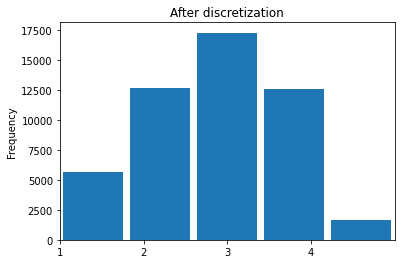

In [53]:
df_merged.rating.plot.hist(bins=5, title = 'After discretization', rwidth=0.9, range=[1,5])

plt.xlim([1, 5])
plt.xticks(np.arange(1, 5, 1))

plt.show()

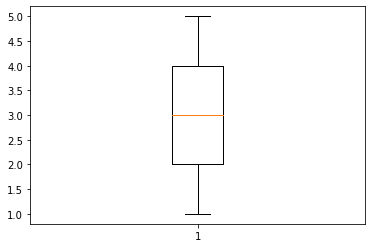

In [54]:
plt.boxplot(df_merged.rating)
plt.show()

In [55]:
df_merged.drop([13438], axis=0, inplace=True)

df_merged.rating.value_counts()

3.0    17254
2.0    12632
4.0    12532
1.0     5638
5.0     1643
Name: rating, dtype: int64

In [56]:

df_def = df_merged


In [57]:
df_def.rating.value_counts()

3.0    17254
2.0    12632
4.0    12532
1.0     5638
5.0     1643
Name: rating, dtype: int64

In [58]:
df_def = df_def.drop(columns= ['rater', 'is_human','original_rating'])


Elimino i duplicati

In [59]:
df_wod = df_def.drop_duplicates()
df_wod.rating.value_counts()

3.0    12357
2.0     9663
4.0     8605
1.0     5026
5.0     1220
Name: rating, dtype: int64

**Eliminare elementi che differiscono solo per la classe**: considero le performances che sono presenti più di una volta nel dataframe e le salvo in un altro dataframe (df_grouped). Questi elementi, avendo già eliminato i duplicati, corrispondono a elementi per i quali sono presenti più rating diversi. A questo dataframe aggiungo un attributo (num_rating) che indica il numero di diversi rating presenti per quella performance.
Successivamente eseguo un outer join tra il dataframe e df_grouped con il risultato di avere nella colonna 'num_rating' NaN per quegli elementi in cui c'è un rating unico.
Salvo in un dataframe proprio questi elementi, eliminando quindi quelli con più rating diversi.

Successivamente elimino attributi non necessari ai fini della classificazione.

In [60]:
df_grouped = df_wod.groupby(['date','team','player']).filter(lambda g: len(g) > 1).groupby(['date','team','player']).size().to_frame('num_ratings')

In [61]:
df_merged2 = pd.merge(df_wod,df_grouped, on =['date','team','player'], how='outer')

df_merged2 = df_merged2[df_merged2.num_ratings.isna()]

df = df_merged2.drop(columns = ['competition','date','match','team','pos_role','player','degree_centrality','moda_pos'])

df.rating.value_counts()

3.0    1906
4.0    1757
2.0    1712
1.0    1111
5.0     190
Name: rating, dtype: int64

*   One-hot encoding per trasformare gli attributi categorici
*   Elimino l'attributo 'num_ratings' che adesso diventa inutile
*   Creo X, y (classe) training e test set





In [62]:
df_mov_onehot = pd.get_dummies(df, columns=['pos'], prefix = ['pos'])
df_mov_onehot = df_mov_onehot.drop(columns= ['num_ratings'])

#Quello giusto
X = df_mov_onehot.loc[:,df_mov_onehot.columns != 'rating']
y = df_mov_onehot.iloc[:,53]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, stratify=y)

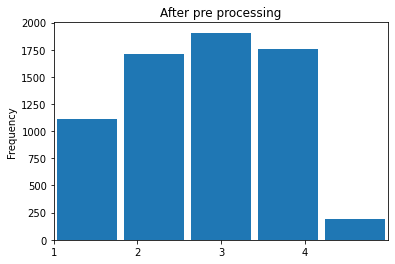

In [63]:
df_mov_onehot.rating.plot.hist(bins=5, title = 'After pre processing', rwidth=0.9, range=[1,5])

plt.xlim([1, 5])
plt.xticks(np.arange(1, 5, 1))

plt.show()

Implementazione "Ordinal classifier". (Non esiste una implementazione in scikit-learn)

In [64]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y-1][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-2][:,1] - clfs_predict[y-1][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-2][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + 1

In [65]:
"""from sklearn.utils.multiclass import type_of_target
type_of_target(X_train)
y_test = y_test.astype(int)
y_train = y_train.astype(int)"""


'from sklearn.utils.multiclass import type_of_target\ntype_of_target(X_train)\ny_test = y_test.astype(int)\ny_train = y_train.astype(int)'

Time to build the model: 2.018679141998291
0.6869695456814778
0.29022479598819334
              precision    recall  f1-score   support

         1.0      0.733     0.760     0.746       333
         2.0      0.644     0.621     0.632       514
         3.0      0.616     0.649     0.632       572
         4.0      0.765     0.734     0.749       527
         5.0      0.836     0.807     0.821        57

    accuracy                          0.687      2003
   macro avg      0.719     0.714     0.716      2003
weighted avg      0.688     0.687     0.687      2003



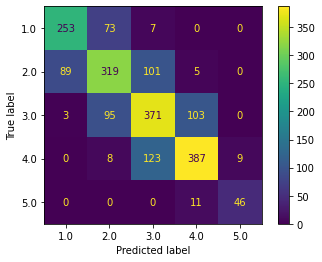

In [66]:
from datetime import time, datetime, date
import time
pipe = Pipeline([
         ('normalization',StandardScaler()),       

         ('feature_sel',SelectFromModel(LogisticRegression(solver='newton-cg'))),
         #('feature_sel',SelectKBest(score_func=f_classif, k=28)),

         #('sampling', RandomOverSampler()),
         #('sampling', SMOTE()),

         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         #('classification', RandomForestClassifier(max_features=17, min_samples_split=3))        
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', svm.SVC(kernel= 'linear',C=0.75,gamma='auto'))
         ('classification', LogisticRegression(solver='newton-cg'))
         #('classification', OrdinalClassifier(DecisionTreeClassifier(max_depth=3)))
    ])
t1 = time.time()
pipe.fit(X_train,y_train)
t2 = time.time()
print(f"Time to build the model: {t2 - t1}")


y_pred = pipe.predict(X_test)

print(accuracy_score(y_pred,y_test))
print(macro_averaged_mean_absolute_error(y_pred,y_test))
print(classification_report(y_test,y_pred,digits = 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#calcola tutti gli alberi e li stampa in un file chiamato out.txt
#pipe['classification'].get_booster().dump_model("out.txt")




### Cross validation

In [67]:
#CROSS VALIDATION
pipe = Pipeline([
         
         ('normalization',StandardScaler()),
         
         #('feature_sel',SelectKBest(score_func=f_classif, k=35)),
         ('feature_sel',SelectFromModel(LogisticRegression(solver='newton-cg'), threshold= 'median')),
  
         #('sampling', SMOTE()),
         #('sampling', RandomOverSampler()),

         
         #('classification',RandomForestClassifier(max_features=17, min_samples_split=3, max_depth=90))
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         ('classification', LogisticRegression(solver='newton-cg'))
         #('classification', svm.SVC(kernel= 'linear',C=0.7,gamma='auto'))
         #('classification', OrdinalClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=6)))

    ])

mamae_scorer = make_scorer(macro_averaged_mean_absolute_error, greater_is_better=True)
balacc_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'prec_weighted': 'precision_weighted',
           'rec_macro': 'recall_macro',
           'rec_weighted': 'recall_weighted',
           'f1_macro': 'f1_macro',
           'f1_weighted': 'f1_weighted',
           'mae': 'neg_mean_absolute_error',
           'rmse': 'neg_root_mean_squared_error',
           'mamae': mamae_scorer,
           'balacc': balacc_scorer}

scores = cross_validate(pipe, X, y, scoring=scoring, cv=StratifiedKFold(10), return_train_score=True, return_estimator = True)
print(scores.keys())
print(f"Macro averaged mean absolute error: {scores['test_mamae']}")
print(f"Macro averaged mean absolute error: {scores['test_mamae'].mean().round(3)}")
print(f"Precision macro: {scores['test_prec_macro'].mean().round(3)}")
print(f"Recall macro: {scores['test_rec_macro'].mean().round(3)}")
print(f"F1 score macro: {scores['test_f1_macro'].mean().round(3)}")
#print(f"Accuracy in each fold: {scores['test_acc']}")
print(f"Average Accuracy: {scores['test_acc'].mean().round(3)}")
#print(f"Avg recall: {scores['test_rec_weighted'].mean().round(3)}")
print(f"time : {scores['score_time'].mean().round(3)}")
#print(f"Avg F1: {scores['test_f1_weighted'].mean().round(3)}")
#print(f"Mean Absolute Error: {scores['test_mae'].mean().round(3)}")
#print(f"Root Mean Squared Error: {scores['test_rmse'].mean().round(3)}")
#print(f"Balanced accuracy: {scores['test_balacc'].mean().round(3)}")

for i in range(10):
  print("Selected features")
  filter = scores['estimator'][i]['feature_sel'].get_support()
  features = np.array(X.columns)
  print(f"Fold {i}: {features[filter]}")



dict_keys(['fit_time', 'score_time', 'estimator', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_prec_weighted', 'train_prec_weighted', 'test_rec_macro', 'train_rec_macro', 'test_rec_weighted', 'train_rec_weighted', 'test_f1_macro', 'train_f1_macro', 'test_f1_weighted', 'train_f1_weighted', 'test_mae', 'train_mae', 'test_rmse', 'train_rmse', 'test_mamae', 'train_mamae', 'test_balacc', 'train_balacc'])
Macro averaged mean absolute error: [0.26918406 0.29955402 0.35035928 0.34374605 0.34600628 0.33333073
 0.33605701 0.31137865 0.29456647 0.28239248]
Macro averaged mean absolute error: 0.317
Precision macro: 0.72
Recall macro: 0.691
F1 score macro: 0.702
Average Accuracy: 0.678
time : 0.024
Selected features
Fold 0: ['goals' 'assists' 'shots_ontarget' 'drib_success' 'keypasses' 'touches'
 'passes_acc' 'passes_inacc' 'crosses_acc' 'lballs_acc' 'grduels_w'
 'aerials_w' 'aerials_l' 'clearances' 'stop_shots' 'interceptions'
 'tackles' 'ycards' 'rcards' 'goals_ag_itb' 's

In [82]:
X = X.loc[:,filter]
model_def = Pipeline([
         ('normalization',StandardScaler()),
         ('classification', LogisticRegression(solver='newton-cg'))
    ])
model_def.fit(X.values,y)

Pipeline(steps=[('normalization', StandardScaler()),
                ('classification', LogisticRegression(solver='newton-cg'))])

In [91]:
#PROVA PREVISIONE
uno = [[10,0,0,0,0,34,20,5,5,1,0,2,11,8,3,0,0,1,0,0,0,0,0,1,0.3,0,0,1,1,1]]
result = model_def.predict(uno)
print(f"The rating is {result}")

The rating is [5.]


Salvo il modello

In [ ]:
#SAVE THE MODEL
import pickle

filename = 'model_mov.sav'
pickle.dump(model_def, open(filename, 'wb'))

In [ ]:
#LOAD THE MODEL
loaded_model = pickle.load(open('model_mov.sav', 'rb'))

In [ ]:
df_movi = X.loc[X.pos_GK == 0,:]
df_gk = X.loc[X.pos_GK == 1,:]

##Weka

Uso le API weka-python wrapper per provare anche CfsSubsetEval + BestFirst per la feature selection

In [ ]:
!pip install javabridge

!pip install python-weka-wrapper3

import weka.core.jvm as jvm
jvm.start()

In [ ]:
#creo i fold e li salvo in delle liste: X_train_base, X_test_base, Y_train_base, Y_test_base
skf = StratifiedKFold(10)

X_train_base=[]
X_test_base=[]
Y_train_base=[]
Y_test_base=[]

for train_index, test_index in skf.split(X,y):

    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_base.append(X_train)
    X_test_base.append(X_test)
    Y_train_base.append(Y_train)
    Y_test_base.append(Y_test)

#print(X_train_base[0])
#print(Y_train_base[0])
#print(X_train_base[1])
#print(Y_train_base[1])

In [ ]:
X_train_base_c = X_train_base.copy()
Y_train_base_c = Y_train_base.copy()

In [ ]:
#converto i df in numpy array in modo da poter essere "letti" da weka
for i in range(10):  
  X_train_base_c[i] = X_train_base_c[i].to_numpy()
  Y_train_base_c[i] = Y_train_base_c[i].to_numpy()

In [ ]:
from weka.core.dataset import create_instances_from_matrices
#creo fold: una lista di dataset
fold = []

for i in range(10):
  fold.append(create_instances_from_matrices(X_train_base_c[i],Y_train_base_c[i]))

In [ ]:
#settiamo la classe in tutti i fold
for i in range(10):
    fold[i].class_is_last()

In [ ]:
#Perform the attribute selection e per ogni fold elimino le features non necessarie, quindi avrò per ogni fold solo le features selezionate
from weka.attribute_selection import ASSearch, ASEvaluation, AttributeSelection
search = ASSearch(classname="weka.attributeSelection.BestFirst", options=["-D", "1", "-N", ""])
evaluator = ASEvaluation(classname="weka.attributeSelection.CfsSubsetEval", options=["-P", "1", "-E", "1"])
attsel = AttributeSelection()
attsel.search(search)
attsel.evaluator(evaluator)

for i in range(10):
  attsel.select_attributes(fold[i])
  print("# attributes: " + str(attsel.number_attributes_selected))
  print("attributes: " + str(attsel.selected_attributes))
  selected_attributes = np.delete(attsel.selected_attributes, attsel.selected_attributes.size-1)
  X_train_base[i]= X_train_base[i].iloc[:,selected_attributes]
  X_test_base[i]= X_test_base[i].iloc[:,selected_attributes]
#print("result string:\n" + attsel.results_string)

# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]
# attributes: 11
attributes: [ 0  1  5 31 33 39 42 43 44 48 52 59]


In [ ]:
import pickle
model = svm.SVC(kernel= 'linear',C=0.7,gamma='auto')

model.fit(X_train_base[7],Y_train_base[7])

filename = 'model_gk2.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Eseguo la classificazione per ogni fold
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import time, datetime, date
import time
accuracies = []
precisions = []
recalls = []
f1s = []
maes = []
rmse = []
build_times = []
pred_times = []
mamae = []

#model = KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance")
model = XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8)
#model = XGBClassifier() #per gk
#model = RandomForestClassifier(min_samples_split=3)
#model = BernoulliNB()
#model = svm.SVC(kernel= 'linear',C=0.7,gamma='auto')
#model = OrdinalClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=6))
#model = OrdinalClassifier(DecisionTreeClassifier(max_depth=3))

for i in range(10):
  t1 = time.time()
  model.fit(X_train_base[i],Y_train_base[i])
  #model.fit(X_train_base_resampled[i],Y_train_base_resampled[i])
  t2 = time.time()
  build_times.append(t2-t1)

  t3 = time.time()
  y_pred = model.predict(X_test_base[i])
  t4 = time.time()
  pred_times.append(t4-t3)

  accuracies.append(accuracy_score(y_pred,Y_test_base[i]))
  precisions.append(precision_score(y_pred,Y_test_base[i],average='macro'))
  recalls.append(recall_score(y_pred,Y_test_base[i],average='macro'))
  f1s.append(f1_score(y_pred,Y_test_base[i],average='macro'))
  maes.append(mean_absolute_error(y_pred,Y_test_base[i]))
  rmse.append(mean_squared_error(y_pred,Y_test_base[i],squared=False))
  mamae.append(macro_averaged_mean_absolute_error(y_pred,Y_test_base[i]))
  print(mamae[i])

print(f"Average accuracy: {np.mean(accuracies).round(3)}")
print(f"Average precision: {np.mean(precisions).round(3)}")
print(f"Average recall: {np.mean(recalls).round(3)}")
print(f"Average f score: {np.mean(f1s).round(3)}")
print(f"Average mean absolute error: {np.mean(maes).round(3)}")
print(f"Average root mean squared error: {np.mean(rmse).round(3)}")
print(f"Average build time: {np.mean(build_times).round(3)}")
print(f"Average prediction time: {np.mean(pred_times).round(3)}")
print(f"MACRO Average mean absolute error: {np.mean(mamae).round(3)}")

In [ ]:
#SAVE THE MODEL
import pickle

filename = 'model_gk.sav'
pickle.dump(model, open(filename, 'wb'))

**IN CASO DI RESAMPLING**: prima eseguire la cella successiva e applicare il fit su X_train_base_resampled e Y_train_base_resampled

In [ ]:
#Eseguo la classificazione per ogni fold
#IN CASO DI RESAMPLING: prima eseguire la cella successiva e applicare il fit su X_train_base_resampled e Y_train_base_resampled
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import time, datetime, date
import time
accuracies = []
precisions = []
recalls = []
f1s = []
maes = []
rmse = []
build_times = []
pred_times = []
mamae = []

model = Pipeline([
                  ('normalization',StandardScaler()),
                  #('classification', LogisticRegression(solver='newton-cg'))
                  #('classification', svm.SVC(kernel= 'linear',C=0.7,gamma='auto'))
                  ('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
])

for i in range(10):
  t1 = time.time()
  #model.fit(X_train_base[i],Y_train_base[i])
  model.fit(X_train_base_resampled[i],Y_train_base_resampled[i])
  t2 = time.time()
  build_times.append(t2-t1)

  t3 = time.time()
  y_pred = model.predict(X_test_base[i])
  t4 = time.time()
  pred_times.append(t4-t3)

  accuracies.append(accuracy_score(y_pred,Y_test_base[i]))
  precisions.append(precision_score(y_pred,Y_test_base[i],average='macro'))
  recalls.append(recall_score(y_pred,Y_test_base[i],average='macro'))
  f1s.append(f1_score(y_pred,Y_test_base[i],average='macro'))
  maes.append(mean_absolute_error(y_pred,Y_test_base[i]))
  rmse.append(mean_squared_error(y_pred,Y_test_base[i],squared=False))
  mamae.append(macro_averaged_mean_absolute_error(y_pred,Y_test_base[i]))

print(f"Average accuracy: {np.mean(accuracies).round(3)}")
print(f"Average precision: {np.mean(precisions).round(3)}")
print(f"Average recall: {np.mean(recalls).round(3)}")
print(f"Average f score: {np.mean(f1s).round(3)}")
print(f"Average mean absolute error: {np.mean(maes).round(3)}")
print(f"Average root mean squared error: {np.mean(rmse).round(3)}")
print(f"Average build time: {np.mean(build_times).round(3)}")
print(f"Average prediction time: {np.mean(pred_times).round(3)}")
print(f"MACRO Average mean absolute error: {np.mean(mamae).round(3)}")

In [ ]:
#REBALANCING
copiax = X_train_base[0].copy()
copiay = Y_train_base[0].copy()

X_train_base_resampled = []
Y_train_base_resampled = []

for i in range(10):
  x_temp, y_temp = RandomOverSampler().fit_resample(X_train_base[i],Y_train_base[i])
  X_train_base_resampled.append(x_temp)
  Y_train_base_resampled.append(y_temp)

##Hyperparameters tuning

In [ ]:
#HYPERPARAMETER TUNING XGBClassifier
from sklearn.model_selection import GridSearchCV

model = XGBClassifier()
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

parameters2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

parameters3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid = GridSearchCV(model, parameters, cv=10, scoring=mamae_scorer)

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

In [ ]:
#HYPERPARAMETER TUNING KNN
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier(n_neighbors= 10)
parameters = {
 'leaf_size':[1,10,15,20,30,40,50],
 'n_neighbors': [5,7,9,10,11,13,15,20,21,22],
 'weights' : ['uniform','distance'],
 'p':(1,2),
 'metric' : ['minkowski','euclidean','manhattan']
}

grid = GridSearchCV(model, parameters, cv=10, scoring = mamae_scorer)

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

the best parameters are 
 {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}


In [ ]:
#HYPERPARAMETER TUNING RANDOM FOREST
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
parameters = {
 'n_estimators':[100,200,300],
 'max_depth': [80, 90, 100, 110],
 'max_features' : ['auto', 'sqrt'],
 'min_samples_leaf': [1,3,5],
 'min_samples_split' : [3,5,8,10]
}

grid = GridSearchCV(model, parameters, cv=10, scoring = mamae_scorer)

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

the best parameters are 
 {'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


In [ ]:
#HYPERPARAMETER TUNING LOGISTIC REGRESSION
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
parameters = {
 'solver':['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

grid = GridSearchCV(model, parameters, cv=10, scoring = mamae_scorer)

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

In [ ]:
#HYPERPARAMETER TUNING DECISION TREE
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
parameters = {

    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]

}

grid = GridSearchCV(model, parameters, cv=10, scoring = mamae_scorer)

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

## Student t-test

In [ ]:
#CROSS VALIDATION
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([
         
         ('normalization',StandardScaler()),
         #('feature_sel',SelectKBest(score_func=f_classif, k=11)),
         ('feature_sel',SelectFromModel(LogisticRegression(solver='newton-cg'), threshold= 'median')),
         #('feature_sel',SelectFromModel(OrdinalClassifier(DecisionTreeClassifier()))), #per gk
         #('feature_sel',VarianceThreshold(threshold= 0.1)),
         #('feature_sel',RFECV(estimator=XGBClassifier())),
         #('feature_sel', ExtraTreesClassifier(n_estimators=10)), 
         #SequentialFeatureSelector(estimator=XGBClassifier(), n_features_to_select = 15, cv =10, direction ='backward'),
  
         #('sampling', SMOTE()),
         #('sampling', RandomOverSampler()),
         #('feature_sel',RFE(estimator=XGBClassifier(), n_features_to_select=30)),
         #('classification', LogisticRegression(C=100,solver='newton-cg'))
         #('classification',RandomForestClassifier(max_features=17, min_samples_split=3, max_depth=90))
         
         #('classification',RandomForestClassifier(max_features=11,  min_samples_split=3))
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         #('classification', XGBClassifier()) #per gk
         #('classification', BernoulliNB()), 
         ('classification', LogisticRegression(solver='newton-cg'))
         #('classification', LogisticRegression())
         #('classification', svm.SVR())
         #('classification', svm.SVC(kernel= 'linear',C=0.7,gamma='auto'))
         #('classification',BaggingClassifier(base_estimator=svm.SVC(kernel= 'linear',C=0.75,gamma='auto',probability=False),n_jobs=-1))
         #('classification', OrdinalClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=6)))
         #('classification', OrdinalClassifier(DecisionTreeClassifier())) #per gk
         #('classification', DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=6))

    ])

mamae_scorer = make_scorer(macro_averaged_mean_absolute_error, greater_is_better=True)
balacc_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'prec_weighted': 'precision_weighted',
           'rec_macro': 'recall_macro',
           'rec_weighted': 'recall_weighted',
           'f1_macro': 'f1_macro',
           'f1_weighted': 'f1_weighted',
           'mae': 'neg_mean_absolute_error',
           'rmse': 'neg_root_mean_squared_error',
           'mamae': mamae_scorer,
           'balacc': balacc_scorer}

scores = cross_validate(pipe, X, y, scoring=scoring, cv=StratifiedKFold(10), return_train_score=True, return_estimator = True)
print(scores.keys())
print(f"Accuracy in each fold: {scores['test_acc']}")
print(f"Average Accuracy: {scores['test_acc'].mean().round(3)}")
print(f"Precision macro: {scores['test_prec_macro'].mean().round(3)}")
#print(f"Avg Precision: {scores['test_prec_weighted'].mean().round(3)}")
print(f"Recall macro: {scores['test_rec_macro'].mean().round(3)}")
#print(f"Avg recall: {scores['test_rec_weighted'].mean().round(3)}")
print(f"F1 score macro: {scores['test_f1_macro'].mean().round(3)}")
#print(f"Avg F1: {scores['test_f1_weighted'].mean().round(3)}")
print(f"Mean Absolute Error: {scores['test_mae'].mean().round(3)}")
print(f"Root Mean Squared Error: {scores['test_rmse'].mean().round(3)}")
print(f"Macro averaged mean absolute error: {scores['test_mamae'].mean().round(3)}")
print(f"Macro averaged mean absolute error: {scores['test_mamae']}")
print(f"Balanced accuracy: {scores['test_balacc'].mean().round(3)}")

for i in range(10):
  print("Selected features")
  filter = scores['estimator'][i]['feature_sel'].get_support()
  features = np.array(X.columns)
  print(f"Fold {i}: {features[filter]}")



<function matplotlib.pyplot.show>

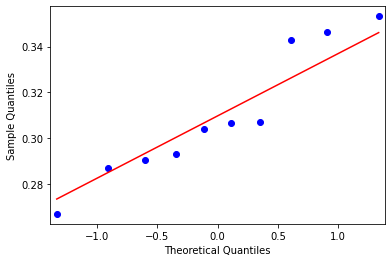

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

qqplot(scores['test_mamae'],line = 's')
pyplot.show

Test di Shapiro-Wilk per la verifica della normalità

In [ ]:
#SHAPIRO WILK TEST
from scipy.stats import shapiro

#stat, p = shapiro(scores['test_mamae'])
#stat, p = shapiro(scores['test_f1_macro'])

#stat, p = shapiro(f1s)
stat, p = shapiro(mamae)

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.964, p=0.835
Sample looks Gaussian (fail to reject H0)


In [ ]:
a_mamae = scores['test_mamae']
a_f1 = scores['test_f1_macro']

In [ ]:
#b_mamae = scores['test_mamae']
#b_f1 = scores['test_f1_macro']

b_mamae = mamae
b_f1 = f1s


In [ ]:
a_acc = scores['test_acc']
#if NOT Gaussian:
a_f1 = np.sqrt(scores['test_f1_macro'])

#a_f1 = scores['test_f1_macro']
a_mae = scores['test_mae']

In [ ]:
from scipy.stats import ttest_rel

# Python paired sample t-test
#print(f"accuracy: {ttest_rel(a_acc, b_acc)}")
print(f"f score: {ttest_rel(a_f1, b_f1)}")
print(f"MA MAE: {ttest_rel(a_mamae, b_mamae)}")

f score: Ttest_relResult(statistic=8.60396971186314, pvalue=1.2318893753609068e-05)
MA MAE: Ttest_relResult(statistic=-2.792830276427196, pvalue=0.020956694826666213)
